In [1]:
import numpy as np
import pandas as pd
import glob
from skimage import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, classification_report, mean_absolute_error


import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Activation, Dropout, Flatten, Dense, Dropout, LayerNormalization, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras
from keras.models import load_model

import pickle

In [2]:
# Dataset is divided in 4 files, this concatenates them all
df_list = []
for file_name in glob.glob("../Data/Raw/Archive/*.txt"):
    df_temp = pd.read_csv(file_name, sep="\t")
    df_list.append(df_temp)
df = pd.concat(df_list, axis=0, ignore_index=True)

In [3]:
df

,user_id,original_image,face_id,age,gender,x,y,dx,dy,tilt_ang,fiducial_yaw_angle,fiducial_score
0,30601258@N03,10399646885_67c7d20df9_o.jpg,1,"(25, 32)",f,0,414,1086,1383,-115,30,17
1,30601258@N03,10424815813_e94629b1ec_o.jpg,2,"(25, 32)",m,301,105,640,641,0,0,94
2,30601258@N03,10437979845_5985be4b26_o.jpg,1,"(25, 32)",f,2395,876,771,771,175,-30,74
3,30601258@N03,10437979845_5985be4b26_o.jpg,3,"(25, 32)",m,752,1255,484,485,180,0,47
4,30601258@N03,11816644924_075c3d8d59_o.jpg,2,"(25, 32)",m,175,80,769,768,-75,0,34
...,...,...,...,...,...,...,...,...,...,...,...,...
19365,7153718@N04,11598838386_349a0d4849_o.jpg,2282,None,NaN,596,460,1472,1473,-75,0,30
19366,7153718@N04,11598166203_c70bb34c80_o.jpg,2283,None,NaN,1179,755,331,331,5,0,108
19367,7153718@N04,11598166203_c70bb34c80_o.jpg,2282,None,NaN,1201,1179,293,293,5,0,99
19368,7153718@N04,11598145163_733cb99713_o.jpg,2282,None,NaN,1027,946,408,408,-85,0,49


In [4]:
df = df.dropna()

In [5]:
df["age"].value_counts()

(25, 32)     4953
(0, 2)       2488
(38, 43)     2293
(4, 6)       2140
(8, 12)      2119
(15, 20)     1642
(60, 100)     867
(48, 53)      825
35            293
13            168
22            149
34            105
23             96
45             88
(27, 32)       77
55             76
36             56
(38, 42)       46
None           40
57             24
3              18
29             11
(38, 48)        6
58              5
2               3
(8, 23)         1
42              1
46              1
Name: age, dtype: int64

Age map to use for regression, this dataset is meant to make the age a classification problem, but we are going to make it a regression one

In [6]:
df = df[df["age"] != "None"]

ages_map = {}
ages_keys = df["age"].value_counts().index
ages_values = []

for x in df["age"].value_counts().index:
    if x.startswith("("):
        x = x.split(", ")
        x[0] = x[0].replace("(","")
        x[1] = x[1].replace(")","")
        x[0] = int(x[0])
        x[1] = int(x[1])
        x = int((x[0]+x[1])/2)
        ages_values.append(x)
    else:
        ages_values.append(int(x))

In [7]:
for key, value in zip(ages_keys, ages_values):
    ages_map[key] = value

In [8]:
df["age"] = df["age"].map(ages_map)

In [9]:
df["gender"].value_counts()

f    9332
m    8120
u    1099
Name: gender, dtype: int64

In [10]:
# We will later make the model predict a non-binary category

df = df[df["gender"] != "u"]
df["gender"] = df["gender"].apply(lambda x: 1 if x == "m" else 0).astype(int)

In [11]:
# Creating the path to the image

df["face_id"] = df["face_id"].astype(str)
df["path"] = "../Data/Raw/Archive/Faces/"+df["user_id"]+"/coarse_tilt_aligned_face."+df["face_id"]+"."+df["original_image"]

In [12]:
df.to_csv("../Data/Clean/Faces.csv")

In [13]:
X = df["path"]
y_age = df["age"]
y_gender = df["gender"]

In [14]:
X_train, X_test, y_train_age, y_test_age = train_test_split(X, y_age, test_size = 0.22, random_state = 22)
X_train, X_test, y_train_gender, y_test_gender = train_test_split(X, y_gender, test_size = 0.22, random_state = 22)

Image greyscaled, downscaled, size adjusted and transformed.

In [15]:
def image_preprocess(path):
    img = tf.io.read_file(np.array(path).ravel()[0])
    img = tf.image.decode_jpeg(img, channels = 1, ratio = 2)
    img = tf.image.resize(img, [64,64])
    img = img / 255 # This part normalizes the image, scaling it down; 255 is the max, while 0 is the min
    return img

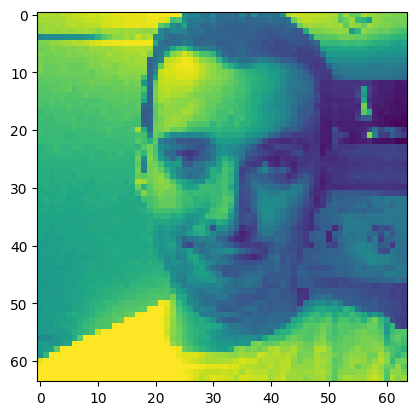

In [16]:
plt.imshow(image_preprocess(df["path"][22]))

In [17]:
# Preparing the data that will be fed to the model

X_train_images = np.array([image_preprocess(path) for path in X_train])
X_test_images = np.array([image_preprocess(path) for path in X_test])

In [18]:
filename = "../Data/Clean/X_train_images.pkl"
with open(filename, "wb") as file:
    pickle.dump(X_train_images, file)

In [19]:
filename = "../Data/Clean/X_test_images.pkl"
with open(filename, "wb") as file:
    pickle.dump(X_test_images, file)

In [20]:
# This changes the learning rate based on epochs

def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr - (lr/(epoch))

In [34]:
model_age = Sequential()
# First layer needs as many nodes as inputs
model_age.add(Conv2D(64,(2,2), activation = "relu", input_shape = (64,64,1)))
model_age.add(MaxPool2D((2,2)))
model_age.add(Conv2D(64,(2,2), activation = "relu"))
model_age.add(MaxPool2D((2,2)))
model_age.add(Conv2D(64,(2,2), activation = "relu"))
model_age.add(MaxPool2D((2,2)))
model_age.add(Flatten())
model_age.add(Dense(64, activation = "relu"))
model_age.add(Dense(1, activation = "relu"))
opt = keras.optimizers.Adam(learning_rate = 0.003)
model_age.compile(optimizer = opt,
              loss = "mse",
              metrics = ["mae", "mse", "mape"])
model_age.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 30, 30, 64)        16448     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 7, 7, 64)        

In [35]:
early_stop = EarlyStopping(patience=5)

checkpoint_path = '../Models/Age_NN7.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [36]:
history = model_age.fit(
    X_train_images, y_train_age,
    epochs=100,
    validation_data = (X_test_images, y_test_age),
    batch_size=128,
    verbose=2,
    callbacks=[early_stop, checkpoint, schedule]
)

Epoch 1/100

Epoch 1: saving model to ../Models\Age_NN7.hdf5
107/107 - 62s - loss: 381.9549 - mae: 14.8937 - mse: 381.9549 - mape: 273.1727 - val_loss: 361.9691 - val_mae: 14.6653 - val_mse: 361.9691 - val_mape: 322.8670 - lr: 0.0030 - 62s/epoch - 582ms/step
Epoch 2/100

Epoch 2: saving model to ../Models\Age_NN7.hdf5
107/107 - 96s - loss: 338.5774 - mae: 14.0133 - mse: 338.5774 - mape: 259.4206 - val_loss: 319.2739 - val_mae: 13.6549 - val_mse: 319.2739 - val_mape: 264.7018 - lr: 0.0030 - 96s/epoch - 898ms/step
Epoch 3/100

Epoch 3: saving model to ../Models\Age_NN7.hdf5
107/107 - 103s - loss: 308.8411 - mae: 13.2441 - mse: 308.8411 - mape: 223.8439 - val_loss: 290.8882 - val_mae: 12.3542 - val_mse: 290.8882 - val_mape: 178.0007 - lr: 0.0030 - 103s/epoch - 964ms/step
Epoch 4/100

Epoch 4: saving model to ../Models\Age_NN7.hdf5
107/107 - 111s - loss: 283.2211 - mae: 12.5119 - mse: 283.2211 - mape: 193.0115 - val_loss: 273.9484 - val_mae: 11.9949 - val_mse: 273.9484 - val_mape: 163.7167

In [37]:
y_train_pred = model_age.predict(X_train_images)
y_test_pred  = model_age.predict(X_test_images)

display(mean_absolute_error(y_train_age,y_train_pred))
display(mean_absolute_error(y_test_age,y_test_pred))

120/120 [==============================] - 4s 32ms/step


7.3948679338093015

8.969506800205757

In [33]:
display(model_age.predict(np.array([image_preprocess("../Data/Test/20Female.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/25Female1.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/25Female2.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/50Female1.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/50Female2.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/50Female3.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/50Female4.jpg")])))

display(model_age.predict(np.array([image_preprocess("../Data/Test/30Male1.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/30Male2.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/30Male3.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/40Male.jpg")])))
display(model_age.predict(np.array([image_preprocess("../Data/Test/50Male.jpg")])))

1/1 [==============================] - 0s 26ms/step


array([[25.59092]], dtype=float32)

1/1 [==============================] - 0s 26ms/step


array([[28.731276]], dtype=float32)

1/1 [==============================] - 0s 27ms/step


array([[46.988113]], dtype=float32)

1/1 [==============================] - 0s 25ms/step


array([[43.32]], dtype=float32)

1/1 [==============================] - 0s 27ms/step


array([[22.43469]], dtype=float32)

1/1 [==============================] - 0s 27ms/step


array([[55.310307]], dtype=float32)

1/1 [==============================] - 0s 29ms/step


array([[41.223095]], dtype=float32)

1/1 [==============================] - 0s 27ms/step


array([[35.03976]], dtype=float32)

1/1 [==============================] - 0s 23ms/step


array([[30.752754]], dtype=float32)

1/1 [==============================] - 0s 29ms/step


array([[54.448174]], dtype=float32)

1/1 [==============================] - 0s 26ms/step


array([[32.294304]], dtype=float32)

1/1 [==============================] - 0s 24ms/step


array([[22.935266]], dtype=float32)

In [231]:
model_age = load_model("../Models/Age_NN3.hdf5")

In [232]:
y_train_pred = model_age.predict(X_train_images)
y_test_pred  = model_age.predict(X_test_images)

display(mean_absolute_error(y_train_age,y_train_pred))
display(mean_absolute_error(y_test_age,y_test_pred))

120/120 [==============================] - 6s 48ms/step


4.357551175066471

7.97575630665912

## Gender

In [216]:
model_gender = Sequential()
# First layer needs as many nodes as inputs
model_gender.add(Conv2D(64,(2,2), activation = "relu", input_shape = (64,64,1)))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Conv2D(64,(2,2), activation = "relu"))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Conv2D(64,(2,2), activation = "relu"))
model_gender.add(MaxPool2D((2,2)))
model_gender.add(Flatten())
model_gender.add(Dense(64, activation = "relu"))
model_gender.add(Dense(1, activation = "sigmoid"))
model_gender.compile(optimizer = "adam",
              loss = "binary_crossentropy",
              metrics = "accuracy")
model_gender.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 63, 63, 64)        320       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_166 (Conv2D)         (None, 30, 30, 64)        16448     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_167 (Conv2D)         (None, 14, 14, 64)        16448     
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 7, 7, 64)       

In [211]:
early_stop = EarlyStopping(patience=5)

checkpoint_path = '../Models/Gender_NN14.hdf5'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=False,
    verbose=1
)

schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [217]:
history = model_gender.fit(
    X_train_images, y_train_gender,
    epochs=50,
    validation_data = (X_test_images, y_test_gender),
    batch_size=128,
    verbose=2,
    callbacks=[early_stop, checkpoint, schedule]
)

Epoch 1/50

Epoch 1: saving model to ../Models\Gender_NN14.hdf5
107/107 - 51s - loss: 0.6152 - accuracy: 0.6488 - val_loss: 0.5823 - val_accuracy: 0.6992 - lr: 0.0010 - 51s/epoch - 473ms/step
Epoch 2/50

Epoch 2: saving model to ../Models\Gender_NN14.hdf5
107/107 - 53s - loss: 0.5278 - accuracy: 0.7348 - val_loss: 0.5298 - val_accuracy: 0.7354 - lr: 0.0010 - 53s/epoch - 495ms/step
Epoch 3/50

Epoch 3: saving model to ../Models\Gender_NN14.hdf5
107/107 - 51s - loss: 0.4695 - accuracy: 0.7752 - val_loss: 0.4835 - val_accuracy: 0.7685 - lr: 0.0010 - 51s/epoch - 476ms/step
Epoch 4/50

Epoch 4: saving model to ../Models\Gender_NN14.hdf5
107/107 - 50s - loss: 0.4340 - accuracy: 0.7969 - val_loss: 0.4531 - val_accuracy: 0.7901 - lr: 0.0010 - 50s/epoch - 467ms/step
Epoch 5/50

Epoch 5: saving model to ../Models\Gender_NN14.hdf5
107/107 - 51s - loss: 0.3968 - accuracy: 0.8205 - val_loss: 0.4207 - val_accuracy: 0.8076 - lr: 0.0010 - 51s/epoch - 474ms/step
Epoch 6/50

Epoch 6: saving model to ../

In [38]:
y_train_pred = model_gender.predict(X_train_images)
y_test_pred  = model_gender.predict(X_test_images)


# This is for binary_crossentropy (1 neuron final output)
y_train_pred2 = [int(round(y_train_pred[x][0],0)) for x in range(len(y_train_pred))]
y_test_pred2 = [int(round(y_test_pred[x][0],0)) for x in range(len(y_test_pred))]


# This is for sparse_categorical_crossestropy (2 neurons final output)
# y_train_pred2 = np.argmax(y_train_pred, axis=1).reshape(-1,1)
# y_test_pred2 = np.argmax(y_test_pred, axis=1).reshape(-1,1)

print("Kappa score:",cohen_kappa_score(y_train_gender, y_train_pred2))
print(classification_report(y_train_gender, y_train_pred2, zero_division = True))
print("Kappa score:",cohen_kappa_score(y_test_gender, y_test_pred2))
print(classification_report(y_test_gender, y_test_pred2, zero_division = True))

NameError: name 'model_gender' is not defined